In [3]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np
import random
import glob
import io+
import os
import math
import random
import base64
import urllib.request
import matplotlib.pyplot as plt

from tqdm import tqdm
from gym import logger as gymlogger
from gym.wrappers import Monitor, AtariPreprocessing, FrameStack
from collections import OrderedDict, deque

%matplotlib inline

/projects/academic/courses/cse546f21/sagarjit/anaconda3/lib/python3.7/site-packages/ale_py/roms/utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


In [4]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 

In [6]:
# urllib.request.urlretrieve('http://www.atarimania.com/roms/Roms.rar','Roms.rar')
# !pip install unrar
# !unrar x Roms.rar
# !mkdir rars
# !mv HC\ ROMS.zip   rars
# !mv ROMS.zip  rars
# !python3 -m atari_py.import_roms rars

In [16]:
class DuelingDQN(nn.Module):
    """Convolutional neural network for the Atari games."""
    def __init__(self, state_size,num_actions):
        super(DuelingDQN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        std = math.sqrt(2.0 / (4 * 84 * 84))
        nn.init.normal_(self.conv1.weight, mean=0.0, std=std)
        self.conv1.bias.data.fill_(0.0)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        std = math.sqrt(2.0 / (32 * 4 * 8 * 8))
        nn.init.normal_(self.conv2.weight, mean=0.0, std=std)
        self.conv2.bias.data.fill_(0.0)

        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        std = math.sqrt(2.0 / (64 * 32 * 4 * 4))
        nn.init.normal_(self.conv3.weight, mean=0.0, std=std)
        self.conv3.bias.data.fill_(0.0)

        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        std = math.sqrt(2.0 / (64 * 64 * 3 * 3))
        nn.init.normal_(self.fc1.weight, mean=0.0, std=std)
        self.fc1.bias.data.fill_(0.0)
        self.V = nn.Linear(512, 1)
        self.A = nn.Linear(512, num_actions)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.00025)

    def forward(self, state_size):
        """Forward pass of the neural network with some inputs."""
        x = F.relu(self.conv1(state_size))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc1(x.view(x.size(0), -1)))  # Flatten imathut.
        V = self.V(x)
        A = self.A(x)
        Q = V + (A - A.mean(dim=1, keepdim=True))
        return Q

In [17]:
class DQNagent:
    '''
    DQNagent is a class that defines the agent.
    '''
    def __init__(self, state_size, action_size, epsilon, epsilon_decay, batch_size, lr, discount_factor, memory_len):
        '''
        Initialize all the parameters that will be used in the learning phase.
        Initital two DQN networks - one is the policy network and the other is the target network
        '''
        self.state_size = state_size
        self.action_size = action_size
        
        self.memory = deque(maxlen=memory_len)
        
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = 0.01
        self.batch_size = batch_size
        self.learning_rate = lr
        self.discount_factor = discount_factor
        
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        self.policy_net = DuelingDQN(self.state_size, self.action_size).to(self.device)
        self.target_net = DuelingDQN(self.state_size, self.action_size).to(self.device)
        self.update_target_policy()
        
    def get_action(self, current_state_vector):
        '''
        This function defines epsilon greedy behavior of the agent.
        '''
        rand_num = np.random.random()
        if rand_num < self.epsilon:
            return np.random.randint(self.action_size)
        else:
            if not torch.is_tensor(current_state_vector):
                current_state_vector = torch.from_numpy(current_state_vector).float().to(self.device)
            
            with torch.no_grad():
                q_values = self.policy_net.forward(current_state_vector).view(-1,)
            best_action = torch.argmax(q_values).item()
        return best_action
    
    def append_memory(self, state, action, reward, next_state, done):
        '''
        Save each experience in the replay memory
        '''
        self.memory.append((state, action, reward, next_state, done))
    
    def update_target_policy(self):
        '''
        Update the target network parameters based on the policy network parameters
        '''
        self.target_net.load_state_dict(self.policy_net.state_dict())
    
    def update_epsilon(self):
        '''
        Perform epsilon decay
        '''
        self.epsilon -= (self.epsilon * self.epsilon_decay)
        return self.epsilon
    
    def preprocess_state(self, state):
        img = state[34:-16, :, :]
        resize = T.Compose([
                    T.ToPILImage(),
                    T.Grayscale(),
                    T.Resize((84, 84)),
                    T.ToTensor()
                ])
        img = resize(img)
        return img.to(self.device)

    def train_model(self):
        '''
        Train the agent
        '''
        if len(self.memory) > self.batch_size:
            mini_batch = random.sample(self.memory, self.batch_size)
            current_state = torch.tensor([]).float().to(self.device)
            actions = list()
            rewards = list()
            next_states = torch.tensor([]).float().to(self.device)
            dones = list()
            
            # Append each memory values in the separate lists
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                current_state = torch.cat((current_state, state)).float().to(self.device)
                actions.append(action)
                rewards.append(reward)
                next_states = torch.cat((next_states, next_state)).float().to(self.device)
                dones.append(done_boolean)
            
            # Convert each list to torch tensors
            actions = torch.from_numpy(np.array(actions)).to(self.device)
            rewards = torch.from_numpy(np.array(rewards)).float().to(self.device)
            dones = torch.from_numpy(np.array(dones)).to(self.device)

            # Make a forward pass in the policy network based on the current state
            # and choose the q-value of the action
            policy_q_values = self.policy_net.forward(current_state).gather(1, actions.view(-1,1)).view(-1,)

            # Make a forward pass in the target network based on the next state
            # and choose the q-value of the action which gives the highest q-value
            policy_best_actions = self.policy_net.forward(next_states).argmax(dim=1).view(-1,1)
            target_q_values = self.target_net.forward(next_states).gather(1, policy_best_actions).view(-1,)
            
            # Compute the target
            y_target = list()
            for index, value in enumerate(target_q_values):
                if dones[index]:
                    y_target.append(rewards[index])
                else:
                    y_target.append(rewards[index] + self.discount_factor * value)
            
            y_target = torch.stack(y_target, dim=0) # Create the list to torch tensor

            # Calculate the MSE loss and perform a backward pass in the policy network
            criterion = nn.MSELoss()
            loss = criterion(y_target, policy_q_values)
            self.policy_net.optimizer.zero_grad()
            loss.backward()

            self.policy_net.optimizer.step()
    
    def test_model(self, agent, env, episodes, perform_render=False):
        '''
        Test the agent behavior after it has been trained
        Agent follows only the greedy policy
        '''
        
        # print('\nTesting the agent after it has been trained')
        # print('Agent chooses only greedy actions from the learnt policy')
        
        total_reward_arr = list()
        timesteps = 0
        self.epsilon = 0
        
        for episode in tqdm(range(episodes)):
            current_state = env.reset()

            obs, _, _, _ = env.step(1)
            current_state = agent.preprocess_state(obs)
            current_state = torch.cat((current_state, current_state, current_state, current_state)).unsqueeze(0)

            dead = False
            done = False
            total_reward = 0
            agent_lives = 5
            
            while not done:
                action = self.get_action(current_state)

                next_state, reward, done, info = env.step(action)
                next_state = agent.preprocess_state(next_state) # 84-84
                next_state_history = torch.cat((current_state.squeeze(0)[1:, :, :], next_state)).unsqueeze(0) # 1-4-84-84

                if agent_lives > info['lives']:
                    dead = True
                    agent_lives = info['lives']

                if dead:
                    obs, _, _, _ = env.step(1)
                    obs = agent.preprocess_state(obs)
                    current_state = torch.cat((current_state.squeeze(0)[2:, :, :], next_state, obs)).unsqueeze(0)
                    dead = False
                else:
                    current_state = next_state_history

                total_reward += reward
                # current_state = next_state
                
                # Render only for the final episode
                if perform_render and episodes-1 == episode:
                    env.render()
            
            total_reward_arr.append(total_reward)
        return total_reward_arr
    
    def save_model(self, filename):
        '''
        Save the trained model
        '''
        torch.save(self.policy_net.state_dict(), filename)
    
    def load_model(self, filename):
        '''
        Load the model
        '''
        self.policy_net.load_state_dict(torch.load(filename))

In [18]:
def plot_graphs(title, total_reward, epsilon_decay, cumulative_reward, avg_timestep, episodes):
    '''
    This functions plots the graphs for rewards, epsilon, success, failure and avergae timesteps
    
    Success is defined when the agent has reached the goal state
    Failure is defined when the agent meets the monster or falls in the pit
    '''
    
    fig, axs = plt.subplots(2,2, figsize=(12,13))
    fig.suptitle(title, fontsize=18)
    fig.tight_layout()
    fig.subplots_adjust(top=0.91, hspace=0.2, wspace=0.2)
    axs[0,0].plot(epsilon_decay)
    axs[0,0].set_title('Epsilon Decay')
    axs[0,0].set_xlabel('Episodes')
    axs[0,0].set_ylabel('Epsilon')
    
    axs[0,1].plot(avg_timestep)
    axs[0,1].set_title('Average timesteps per 50 episodes')
    axs[0,1].set_xticks(np.arange(len(avg_timestep)))
    axs[0,1].set_xticklabels(list(range(0,episodes+1,50))[1:], rotation=90)
    axs[0,1].set_xlabel('Episodes')
    axs[0,1].set_ylabel('Timesteps')
    
    axs[1,0].plot(total_reward)
    axs[1,0].set_title('Total Reward per episode')
    axs[1,0].set_xlabel('Episodes')
    axs[1,0].set_ylabel('Rewards')
    
    axs[1,1].plot(cumulative_reward)
    axs[1,1].set_title('Cumulative reward over all episodes')
    axs[1,1].set_xlabel('Episodes')
    axs[1,1].set_ylabel('Cumulative Rewards')
    
    plt.show()

In [19]:
# Parameters
env = gym.make('BreakoutDeterministic-v4')
state_size = env.observation_space.shape
action_size = env.action_space.n

epsilon = 1.0
epsilon_decay = 0.0001

batch_size = 32
lr = 0.00025
discount_factor = 0.99
update_frequency = 5

memory_len = 100000
episodes = 50000
test_episodes = 100
perform_render = False

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"

total_reward_arr = list() # Store total reward per episode values
cumulative_reward_arr = list() # Store cumulative reward
epsilon_decay_arr = [epsilon] # Store each epsilon value after decay
timestep_arr = list() # Store the timestep per episode
avg_timestep_arr = list() # Store average timestep every 20 episodes
test_total_reward_arr = list()

agent = DQNagent(state_size, action_size, epsilon, epsilon_decay, batch_size, lr, discount_factor, memory_len)
success_count = 0
failure_count = 0
train_timestep = 8

for episode in tqdm(range(episodes)):
    done = False
    dead = False
    # perform_fire = True

    total_reward = 0
    timesteps = 0
    agent_lives = 5
    env = gym.make('BreakoutDeterministic-v4')
    current_state = env.reset() 

    obs, _, _, _ = env.step(1)
    current_state = agent.preprocess_state(obs)
    current_state = torch.cat((current_state, current_state, current_state, current_state)).unsqueeze(0) # 1-4-84-84
    # print(f'\nEpisode: {episode}, Agent Lives: {agent_lives}')
    
    while not done:        
        action = agent.get_action(current_state)
        
        next_state, reward, done, info = env.step(action)
        # print(f"Lives: {info['ale.lives']}")
        next_state = agent.preprocess_state(next_state) # 84-84
        next_state_history = torch.cat((current_state.squeeze(0)[1:, :, :], next_state)).unsqueeze(0) # 1-4-84-84
        
        agent.append_memory(current_state, action, reward, next_state_history, done)

        if agent_lives > info['lives']:
            dead = True
            agent_lives = info['lives']

        if timesteps % train_timestep == 0:
            agent.train_model()

        total_reward += reward
        timesteps += 1
        
        if dead:
            obs, _, _, _ = env.step(1)
            obs = agent.preprocess_state(obs)
            current_state = torch.cat((current_state.squeeze(0)[2:, :, :], next_state, obs)).unsqueeze(0)
            # plt.imshow(current_state.squeeze(0).cpu().detach().numpy()[1, :, :])
            # plt.imshow(current_state.squeeze(0).cpu().detach().numpy()[2, :, :])
            # plt.imshow(current_state.squeeze(0).cpu().detach().numpy()[3, :, :])
            # plt.imshow(obs[0,:,:].cpu().detach().numpy())
            # plt.imshow(current_state.squeeze(0).cpu().detach().numpy())
            # print(current_state.shape)
            # print(f'Episode: {episode}, Agent Lives: {agent_lives}, done: {done}')
            dead = False
        else:
            current_state = next_state_history

    if episode % update_frequency == 0:
        agent.update_target_policy()

    epsilon = agent.update_epsilon()
    epsilon_decay_arr.append(epsilon)

    timestep_arr.append(timesteps)

    # Calculate average timesteps for 50 timesteps
    if done and (episode+1) % 50 == 0:
        avg_timestep_arr.append(np.average(timestep_arr))
        timestep_arr.clear()

    total_reward_arr.append(total_reward)

    if np.mean(total_reward_arr[-20:]) > 200:
        break
    
    if total_reward > 200:
        with open("200_log.txt", "a") as handle:
            handle.write(f"Episode: {episode}. Reward: {total_reward}\n")
        agent.save_model(f"./model_weights/Dueling_DQN_breakout_weights_{episode}.pth")

    if episode >= 12000:
        with open("reward_check.txt", "a") as handle:
            handle.write(f"Episode: {episode}. Reward: {total_reward}\n")

    if episode % 100 == 0:
        with open("log.txt", "a") as handle:
            handle.write(f"Episode: {episode}. Total Reward: {total_reward}\n")
#         print(f"Episode: {episode}. Total Reward: {total_reward}")

    if len(cumulative_reward_arr) == 0:
        cumulative_reward = total_reward
    else:
        cumulative_reward = cumulative_reward_arr[-1] + total_reward
    cumulative_reward_arr.append(cumulative_reward)

# Save the model weights
agent.save_model("Dueling_DQN_breakout_weights.pth")

# Test the agent
# test_total_reward_arr = agent.test_model(agent, env, test_episodes, perform_render=perform_render)

 57%|█████▋    | 28628/50000 [15:03:31<13:28:17,  2.27s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



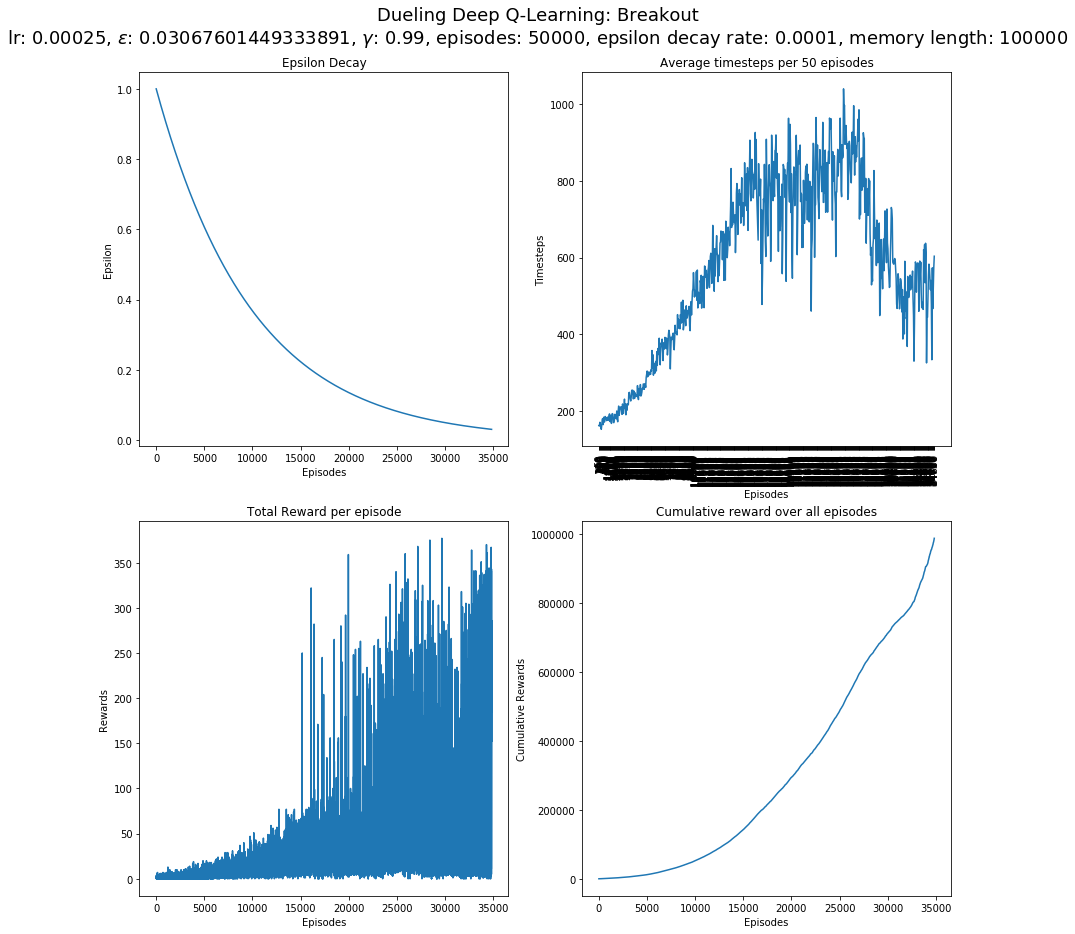

In [22]:
# Plot graphs
title = 'Dueling Deep Q-Learning: Breakout\n' + r'lr: {}, $\epsilon$: {}, $\gamma$: {}, episodes: {}, epsilon decay rate: {}, memory length: {}'.format(lr, epsilon, discount_factor, episodes, epsilon_decay, memory_len)

plot_graphs(title, total_reward_arr, epsilon_decay_arr, cumulative_reward_arr, avg_timestep_arr, episodes)

In [23]:
# Test the agent after training
test_total_reward_arr = agent.test_model(agent, env, test_episodes, perform_render=perform_render)


100%|██████████| 100/100 [02:05<00:00,  1.25s/it]


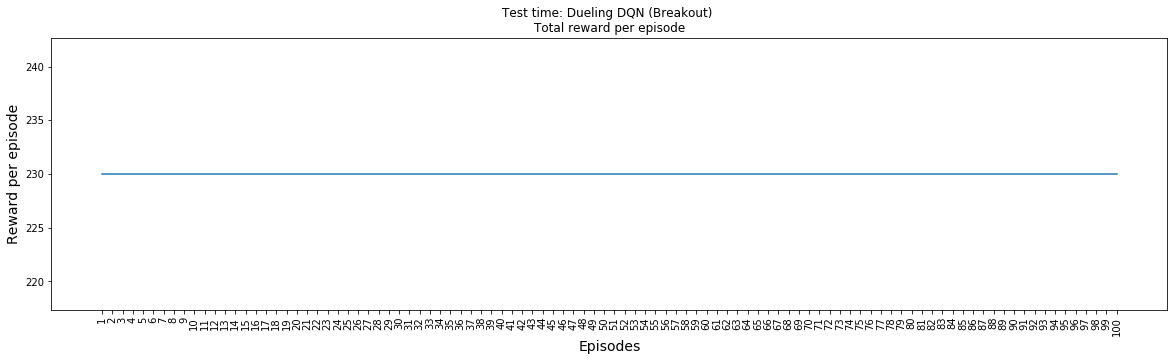

In [24]:
fig = plt.figure(figsize=(20,5))
plt.plot(test_total_reward_arr)
plt.title('Test time: Dueling DQN (Breakout) \nTotal reward per episode')
plt.xlabel('Episodes', fontsize=14)
plt.ylabel('Reward per episode', fontsize=14)
plt.xticks(np.arange(100), np.arange(1,101), rotation=90)
plt.show()

### Test agent on saved weights

In [25]:
test_episodes = 100

In [28]:
agent = DQNagent(state_size, action_size, epsilon, epsilon_decay, batch_size, lr, discount_factor, memory_len)
agent.load_model("Dueling_DQN_breakout_weights.pth")
test_rewards = agent.test_model(agent, env, test_episodes, perform_render=perform_render)


100%|██████████| 100/100 [02:05<00:00,  1.25s/it]


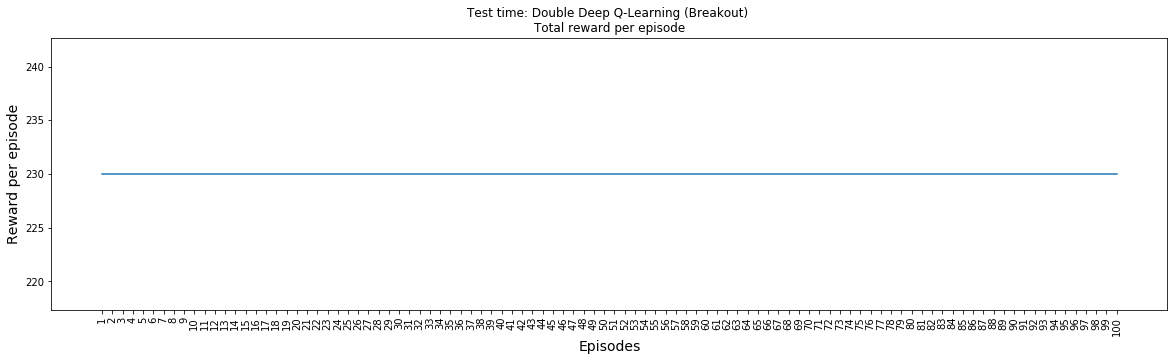

In [29]:
fig = plt.figure(figsize=(20,5))
plt.plot(test_rewards)
plt.title('Test time: Double Deep Q-Learning (Breakout) \nTotal reward per episode')
plt.xlabel('Episodes', fontsize=14)
plt.ylabel('Reward per episode', fontsize=14)
plt.xticks(np.arange(100), np.arange(1,101), rotation=90)
plt.show()